# Simulation of Outlier Detection
> Circle

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

Circle(n=5000, 음수쪽 3%. 양수쪽 2%)

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.972**|**0.989**|**0.982**|**0.985**|
|LOF (Breunig et al., 2000)|0.865|0.950|0.905|0.927|
|OCSVM (Sch¨olkopf et al., 2001)|0.921|0.985|0.932|0.957|
|ABOD (Kriegel et al., 2008)|0.970|0.984|0.984|0.984|
|Isolation Forest (Liu et al., 2008)|0.855|0.993|0.853|0.918|

Circle(n=5000, 음수쪽 8%. 양수쪽 2%)
```python
signal = sample(c(runif(n*0.08,-7,-6), runif(n*0.02,6,8), rep(0,n*0.90)))
```

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.907**|**0.980**|**0.916**|**0.947**|
|LOF (Breunig et al., 2000)|0.830|0.903|0.908|0.906|
|OCSVM (Sch¨olkopf et al., 2001)|0.871|0.928|0.928|0.928|
|ABOD (Kriegel et al., 2008)|0.912|0.928|0.979|0.953|
|Isolation Forest (Liu et al., 2008)|0.785|0.905|0.850|0.877|

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

from alibi_detect.od import IForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
import seaborn as sns

from PyNomaly import loop

from sklearn import svm

## Circle

### 1. Simul, ABOD

In [7]:
%load_ext rpy2.ipython

In [618]:
%%R
library(EbayesThresh)
set.seed(1)
n=5000
epsilon = rnorm(n)
signal = sample(c(runif(n*0.12,-7,-3), runif(n*0.02,6,7), rep(0,n*0.86)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier
x=signal+epsilon

In [619]:
%R -o x
%R -o index_of_trueoutlier
%R -o signal

In [620]:
n=5000

In [621]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [622]:
outlier_true_index = index_of_trueoutlier

outlier_true_value = x[index_of_trueoutlier]

In [623]:
outlier_true_one = signal.copy()

In [624]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

In [625]:
r=x+10
θ = np.linspace(-3.14,3.14,len(x))

In [626]:
_x = r*np.cos(θ)
_y = r*np.sin(θ)

In [627]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [628]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [629]:
_df['ABOD_Clf'] = abod_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

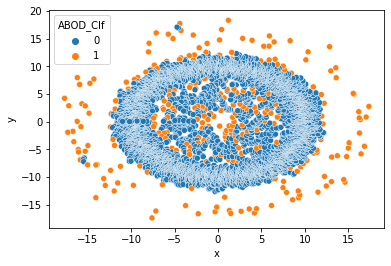

In [630]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

In [631]:
outlier_ABOD_one = list(abod_clf.labels_)

In [632]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [633]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [634]:
w=np.zeros((n,n))

In [635]:
for i in range(n):
    for j in range(n):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [636]:
_simul = SIMUL(_df)

In [637]:
_simul.fit(sd=20)

In [638]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [639]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [640]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [641]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

In [642]:
_simul.df=_simul.df.assign(one = outlier_simul_one)

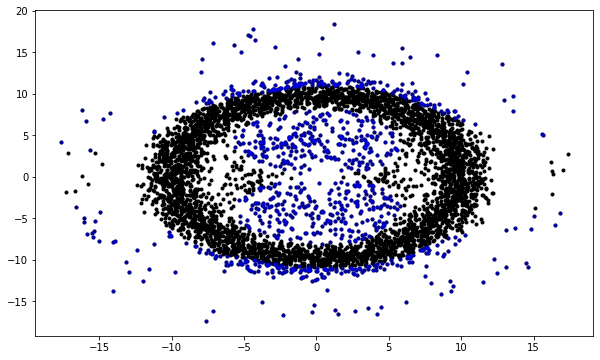

In [643]:
plt.figure(figsize=(10,6))
plt.plot(_simul.df['x'],_simul.df['y'],'k.')
plt.plot(_simul.df.iloc[outlier_simul_first_index]['x'],_simul.df.iloc[outlier_simul_first_index]['y'],'b.',alpha=0.5)

In [644]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

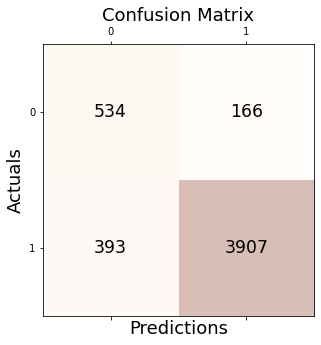

In [645]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [646]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.888
Precision: 0.959
Recall: 0.909
F1 Score: 0.933


In [647]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [649]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.885
Precision: 0.892
Recall: 0.985
F1 Score: 0.936


### 2. LOF

In [650]:
X = np.array(_df)

In [651]:
clf = LocalOutlierFactor(n_neighbors=2)

outlier

In [652]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [653]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [654]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

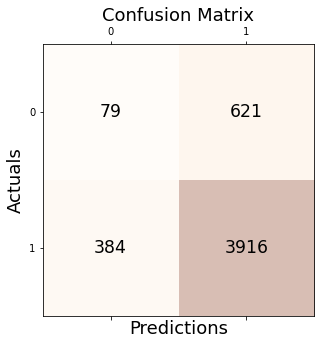

In [655]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [656]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.799
Precision: 0.863
Recall: 0.911
F1 Score: 0.886


### 3. forest

In [657]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [658]:
od.fit(_df[['x', 'y']])

In [659]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

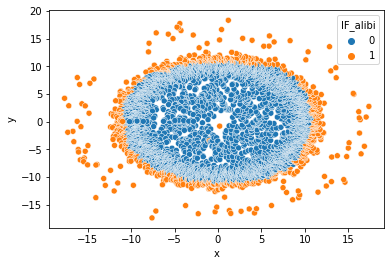

In [660]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [661]:
outlier_alibi_one = _df['IF_alibi']

In [662]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [663]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

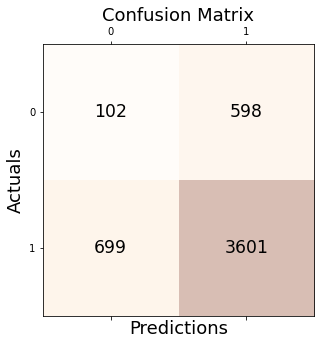

In [664]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [665]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.741
Precision: 0.858
Recall: 0.837
F1 Score: 0.847


### 4. SVM

In [666]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [667]:
_df = np.array(_df).reshape(-1,2)

In [668]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [669]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [670]:
y_pred = clf.predict(_df)

In [671]:
_df.shape

(5000, 2)

In [672]:
outlier_OSVM_one = list(clf.predict(_df))

In [673]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

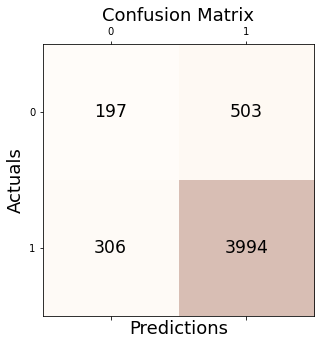

In [674]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [675]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.838
Precision: 0.888
Recall: 0.929
F1 Score: 0.908
